# Stochastic Optimization Example (SWASD quickstart)

We generate a synthetic sequence of iterates that clearly shows the two phases: the transient/burn-in phase and the stationary phase in a Markov chain. We run the SWASD algorithm to automatically decide whether a given sequence of iterations has converged and where it becomes stationary if we conduct the convergence checks adaptively.

## Synthetic Data Model

We generate synthetic stochastic optimization updates that transition from a transient phase to a stationary phase.

$$
x_t = x_* + a(t)\,v + z_t,
\quad
a(t)=\left(\frac{t_0}{t+t_0}\right)^\alpha,
\quad
z_t = \rho z_{t-1} + \sigma\,\epsilon_t,\ 
\epsilon_t\sim\mathcal{N}(0,I).
$$

Here, $x_*$ denotes the optimum point of the optimization, while the term $a(t)\,v$ captures the non-stationary transient phase, with $t_0$ and $\alpha$ controlling how quickly the iterates approach stationarity. The stochastic component $z_t$ models the oscillations around the optimum $x_*$ through an AR(1) process, where $\rho$ controls the autocorrelation and $\sigma$ controls the noise scale.

Note that we typically do not know $x_*$ or the stationary distribution in practice. We use this example, where we know the ground truth, to validate our convergence diagnostic.

In [60]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import seaborn as sns
from swasd.algorithm import check_is_converged, check_where_converged
from swasd.plotting import (
    swd_comparison_plot,
    regression_diagnostic_plot,
    convergence_plot,
    trace_plot,
)
import nest_asyncio

nest_asyncio.apply()
np.set_printoptions(precision=3, suppress=True)

sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2})
sns.set_palette('colorblind', n_colors=30)
sns.set_style("ticks", {"axes.spines.right": False,
        "axes.spines.top": False})


In [61]:
# synthetic model iterate generating function

def generate_optim_iterates_simple(
    steps: int = 50000,
    d: int = 5,
    seed: int = 0,
    *,
    x_star=None,
    t0: float = 100.0,
    alpha: float = 1.20,
    rho: float = 0.99,
    sigma: float = 1.5e-4,
    v=None,
):
    rng = np.random.default_rng(seed)

    if x_star is None:
        x_star = np.zeros(d)
    else:
        x_star = np.asarray(x_star, float)

    if v is None:
        v = rng.normal(size=d)
        v = v / (np.linalg.norm(v) + 1e-12) * 2.0  # initial offset magnitude
    else:
        v = np.asarray(v, float)

    z = np.zeros(d)
    X = np.empty((steps, d), float)

    for t in range(steps):
        tt = t + 1
        a = (t0 / (tt + t0)) ** alpha
        z = rho * z + sigma * rng.normal(size=d)
        X[t] = x_star + a * v + z

    return X


**Step 1 - Generate synthetic iterates**

We first create a matrix `X` with shape `(num_iters, num_dims)` that contains the stochastic optimization iterates. Here, each row represents one iteration of the algorithm, and each column represents one parameter.

In [62]:
T = 50000
d = 3

X = generate_optim_iterates_simple(steps=T, d=d)

In this example, iterates starts far from the stationarity and then gradually move towards the stationarity.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Parameter Value'>)

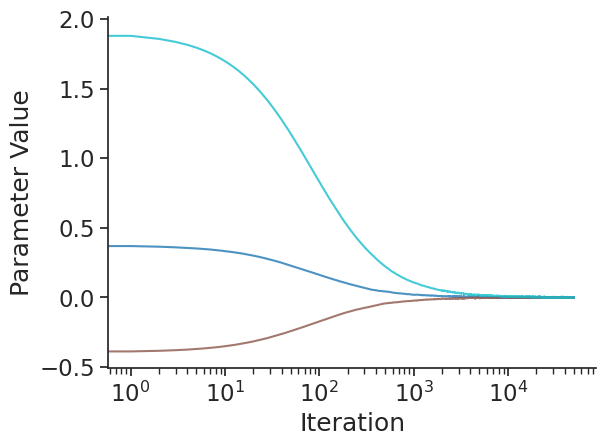

In [64]:
trace_plot(X, xlog=True)

**Step 2 - Generate stationary samples (optional, for validation only)**

We create a stationary sample to compare the estimated values of $\mathcal{SW}_{p,\Sigma}(\pi_{(i)},\pi)$, for $i=1,\ldots,B$, with the ground truth.

If you are applying SWASD to real MCMC or Stochastic optimization output, please skip this step.

In [65]:
def sample_stationary_reference(n, d, x_star, rho, sigma, seed=0):
    rng = np.random.default_rng(seed)
    x_star = np.asarray(x_star, float)
    var = (sigma**2) / (1.0 - rho**2)
    return x_star[None, :] + rng.normal(size=(n, d)) * np.sqrt(var)

X_true = sample_stationary_reference(n=1000, d=d, x_star=np.zeros(d), rho=0.99, sigma=1.5e-4)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Parameter Value'>)

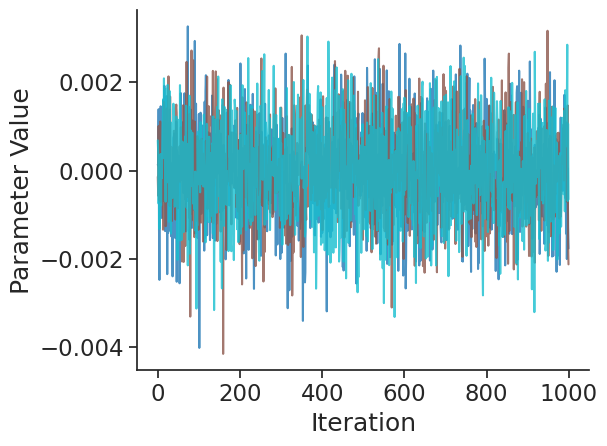

In [66]:
trace_plot(X_true, xlog=False)

**Step 3 - Run SWASD to check convergence**

The `check_is_converged(X)` runs the diagnostic once at sample `X` and prints out whether the sample converged or not. It also returns a `results` object with diagnostics (which users can use for plotting).

In [67]:
convg_results = check_is_converged(X, true_samples=X_true)

[SWASD] k=50000 >= 1500 (= min_iters_per_block*n_blocks). Running SWASD only (n_blocks=6, threshold=1.0).
Converged at k=50000 via SWD(estimated final distance=0.8609 < 1.0).


**Step 4 - Diagnose the SWD regression fit**

SWASD works by first computing pairwise sliced Wasserstein distances between blocks of the iterations. The blocks are obtained by dividing the iteration into equal-sized blocks. Then it fit a monoton decay regression model to estimate $\mathcal{SW}_{p,\Sigma}(\pi_{(i)},\pi)$ for $i=1,\ldots,B$.

The following plot compares the observed pairwise distances with the fitted values obtained from the regression model. If the fitted values are closer to the observed values, the monotone model is a good approximation. Large deviations may suggest the model assumptions are not capturing the true pairwise distance behavior.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Block Pairs', ylabel='$\\mathrm{SWD}(\\hat{\\pi}_{(i)}, \\hat{\\pi}_{(j)})$'>)

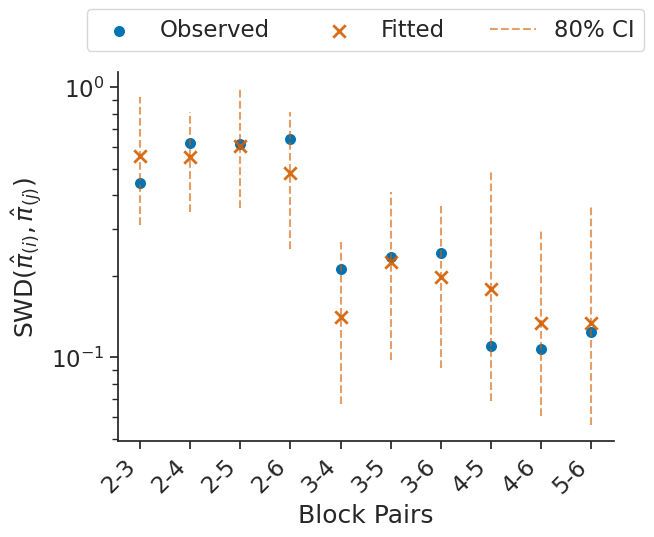

In [70]:
regression_diagnostic_plot(convg_results)

**Step 5 - Compare estimated vs. true sliced Wasserstein distance**
 
Because we have the ground truth of the synthetic example, we can compute the $\mathcal{SW}_{2,\Sigma}(\pi_{(i)},\pi)$ and compare it with the estimated value SWASD produces.

From the following plot, we can check whether the estimates we get from SWASD are reliable or not.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\mathrm{SWD}(\\pi_{(i)}, \\pi)$', ylabel='$\\widehat{\\mathrm{SWD}}(\\pi_{(i)}, \\pi)$'>)

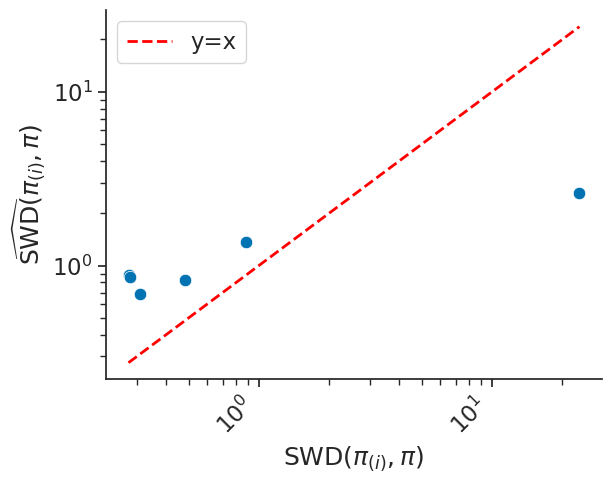

In [71]:
swd_comparison_plot(convg_results)

The SWASD framework also has `check_where_converged()`, where it runs convergence checks of the sample `X` at a sequence of checkpoints over the iterations. It prints out where the convergence was first detected or `None` if it never detect convergece, and it returns a `results` object with diagnostics similar to  `check_is_converged()`.

In [72]:
convg_where_results = check_where_converged(X, true_samples=X_true)

SWASD Convergence Detection:  95%|█████████▌| 40/42 [12:31<00:37, 18.78s/check, k=4e+4, rhat=2.604, SWD=1.195] 


CONVERGENCE DETECTED!
Convergence at iteration: 39968
Detection method: SWD
Final SWD distance: 0.6986 (threshold: 1.0000)

Rhat checks performed: 22
Best Rhat achieved: 1.8896

SWD checks performed: 19
Initial SWD: 2.8227
Final SWD: 0.6986


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Block Pairs', ylabel='$\\mathrm{SWD}(\\hat{\\pi}_{(i)}, \\hat{\\pi}_{(j)})$'>)

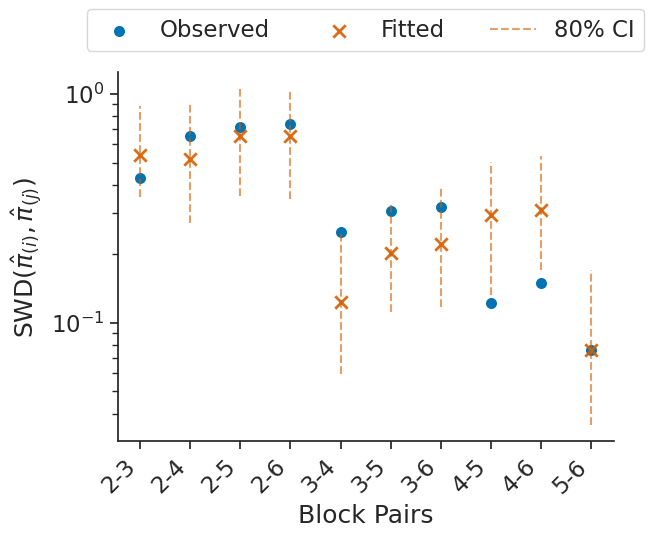

In [73]:
regression_diagnostic_plot(convg_where_results)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\mathrm{SWD}(\\pi_{(i)}, \\pi)$', ylabel='$\\widehat{\\mathrm{SWD}}(\\pi_{(i)}, \\pi)$'>)

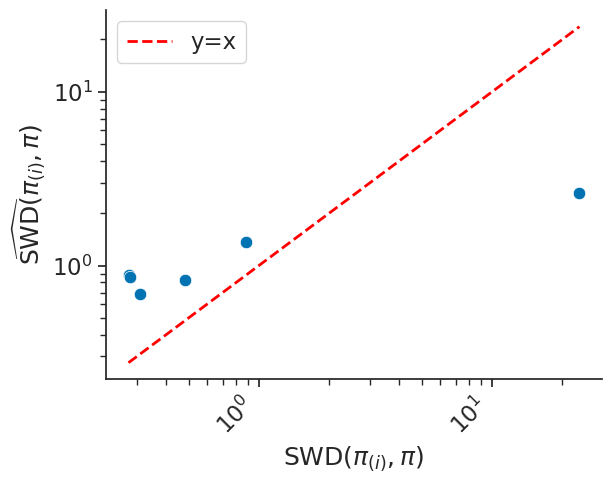

In [74]:
swd_comparison_plot(convg_results)

In SWASD, we are looking at $\widehat{\mathcal{SW}}_{2,\Sigma}(\pi_{(B)},\pi) < \varepsilon$, where $\varepsilon$ is the convergence threhold and $B$ is the last block, to declare convergence.

The following plot shows values of $\widehat{\mathcal{SW}}_{2,\Sigma}(\pi_{(B)},\pi)$ and the ground truth $\mathcal{SW}_{2,\Sigma}(\pi_{(B)},\pi)$ at the check points where we check for convergence.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Diagnostic Value'>)

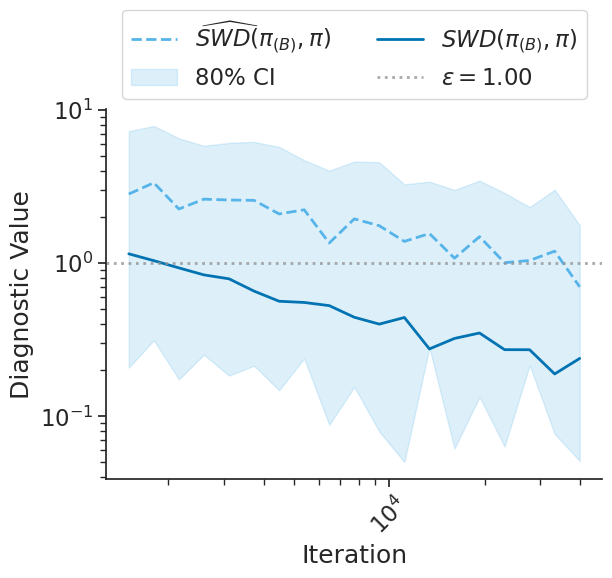

In [75]:
convergence_plot(convg_where_results)